In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import time
#A continuación se importan laas librerias necesarias para el entrenamiento de la red 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import ConvLSTM2D
from keras.layers import Flatten


Using TensorFlow backend.


(210584,)


Text(0.5, 1.0, 'Datos reales')

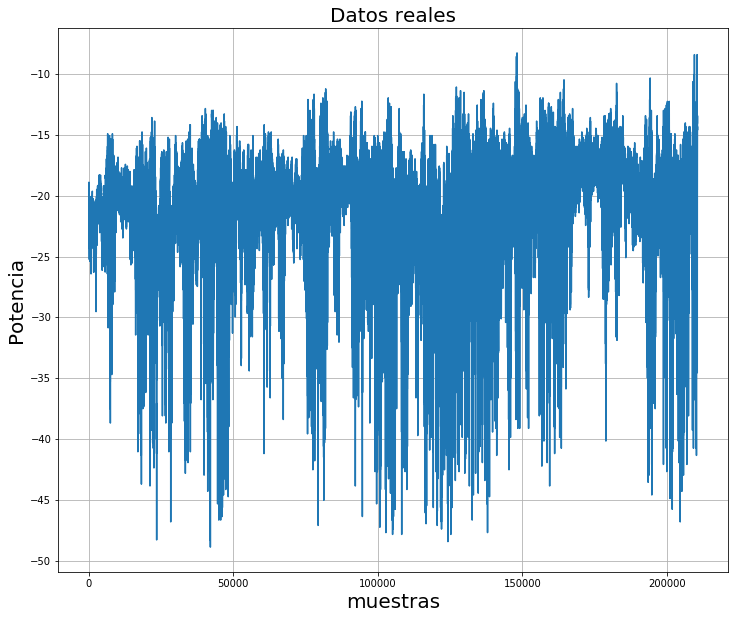

In [3]:
dataframe = pd.read_csv('/content/drive/My Drive/LSTM /Mediciones en csv/HTNLOS CSV/potencia 2000-01-02 19_3A27_3A19 Antenna Horn Time 300[s] SwitchingBy 0 Horn 0 Omni 0 ING-AU_025.csv', header=None )
#llevar al dataframe a un arreglo de valores
dataset = dataframe.values
#dataset solo para la funcion senoidal
POT = dataset[0:len(dataset),1]
#POT = dataset
print(POT.shape)
plt.figure(figsize=[12,10])
plt.grid()
plt.plot(POT)
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.title("Datos reales", fontsize = 20)

# Nueva sección

In [4]:
#llevo la funcion a un arreglo de [lARGO DEL ARREGLO ,1] PARA ESCALAR LOS DATOS y que la red aprenda de mejor forma
POT2=POT.reshape(len(POT),1)
print(POT2.shape)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
POT2 = scaler.fit_transform(POT2)

(210584, 1)


In [5]:
# divido la funcion y1 en arreglos para entrenar y probar la red
train_size = int(len(POT2) * 0.8)
test_size = len(POT2) - train_size
train, test = POT2[0:train_size,:], POT2[train_size:len(POT2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

168467 42117
(168467, 1)
(42117, 1)


In [0]:
# convertir un arreglo de valores en una matrix
def create_dataset(POT2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(POT2)-look_back-1):
        a = POT2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(POT2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# reshape dentro X=t and Y=t+1
look_back = 128
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
#print(trainX[0])
#print(trainY[0])
#print(trainX[1])
#print(trainY[1])
#print(trainX[2])
#print(trainY[3])

(168338, 128)
(41988, 128)
(168338,)
(41988,)


In [0]:
#n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length, n_features = 4, 32, 1
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 4, 1, 30, 128)     198656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 1, 30, 128)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 28, 128)        393728    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 28, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3585      


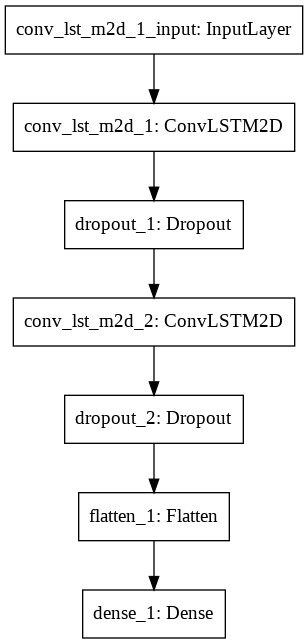

In [9]:
model = Sequential()
model.add(ConvLSTM2D(filters=128, kernel_size=(1,3), return_sequences = True ,activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
#model.add(ConvLSTM2D(filters=32, kernel_size=(1,3), input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.3))
model.add(ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
#model.add(LSTM(input_shape = (None, None, 32, 1), output_dim= 128, return_sequences = True))
model.add(Dropout(0.3))
#model.add(LSTM(128))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.summary()
keras.utils.plot_model(model, 'my_first_model.png')

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
filepath="Checkpoint_mejores_pesos_señal_htnlos_S2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_percentage_error', verbose=1, save_best_only=True, mode='min')
# simple early stopping
es = EarlyStopping(monitor='val_mean_absolute_percentage_error', mode='min', verbose=1, patience=5)

In [11]:
batch_size= 64 
epochs= 30
start = time.time()
History_htnlos2 = model.fit(trainX, trainY,batch_size=batch_size, epochs= epochs, callbacks=[es, checkpoint] , validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 151504 samples, validate on 16834 samples
Epoch 1/30





151504/151504 [==============================] - 125s 825us/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0553 - mean_absolute_percentage_error: 4294.4729 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0475 - val_mean_absolute_percentage_error: 7.2331

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 7.23306, saving model to Checkpoint_mejores_pesos_señal_htnlos_S2.hdf5
Epoch 2/30
151504/151504 [==============================] - 108s 711us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0469 - mean_absolute_percentage_error: 3956.6719 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0447 - val_mean_absolute_percentage_error: 6.6021

Epoch 00002: val_mean_absolute_percentage_error improve

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_htnlos_señal2.json", "w") as json_file:
    json_file.write(model_json)


In [0]:
import pickle

pickle_out = open("History_htnlos2.pickle","wb")
pickle.dump(History_htnlos2, pickle_out)
pickle_out.close()

In [0]:
import pickle 

pickle_in = open("History_htnlos2.pickle","rb")
History_saved = pickle.load(pickle_in)


In [0]:
History = History_saved

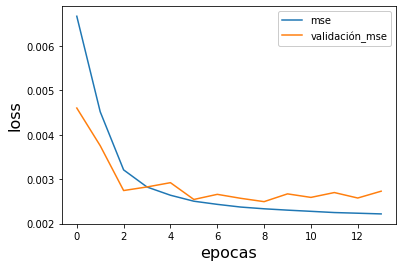

In [16]:
# plot metrics
#plt.figure(figsize=[8,8])
plt.plot(History.history['mean_squared_error'], label='mse')
plt.plot(History.history['val_mean_squared_error'], label= 'validación_mse')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

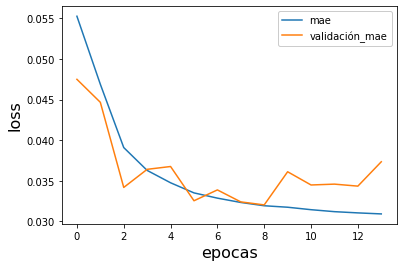

In [17]:
plt.plot(History.history['mean_absolute_error'], label='mae')
plt.plot(History.history['val_mean_absolute_error'], label= 'validación_mae')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [0]:
#History.history['mean_absolute_percentage_error']

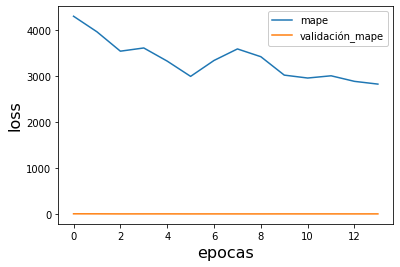

In [19]:
plt.plot(History.history['mean_absolute_percentage_error'], label= 'mape')
plt.plot(History.history['val_mean_absolute_percentage_error'], label= 'validación_mape')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [20]:
# predicciones de los valores de prueba
prediccion_test = model.predict(testX)
prediccion_test = scaler.inverse_transform(prediccion_test)
#actuals = test_y
valor_real_test = scaler.inverse_transform([testY])
valor_real_test= valor_real_test.reshape(len(prediccion_test),1)
#prediccion de los valores de entrenamiento
aprendido=model.predict(trainX)
aprendido_train=scaler.inverse_transform(aprendido)
reales_train=scaler.inverse_transform([trainY])
reales_train=scaler.inverse_transform([trainY])
reales_train=reales_train.reshape(len(aprendido),1)
###################################################
mse_aprendido=mean_squared_error(reales_train,aprendido_train)
mse_test=mean_squared_error(valor_real_test,prediccion_test)
print('Train Mean square Error:', mse_aprendido)
print('Test Mean square Error:', mse_test)
#######################################################
rmse_train=math.sqrt(mse_aprendido)
rmse_test=math.sqrt(mse_test)
print('Train Root Mean Squared Error:', rmse_train)
print('Test Root Mean Squared Error:', rmse_test)


Train Mean square Error: 3.5226463682598395
Test Mean square Error: 2.389458151560953
Train Root Mean Squared Error: 1.8768714309349588
Test Root Mean Squared Error: 1.545787227130873


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
#mape train
mean_absolute_percentage_error(reales_train,aprendido_train)

6.137545362619494

In [23]:
#mape test
mean_absolute_percentage_error(valor_real_test,prediccion_test)

5.730594759325116

In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [25]:
smape(reales_train,aprendido_train)

5.973908290291624

In [26]:
smape(valor_real_test,prediccion_test)

5.559103534475232

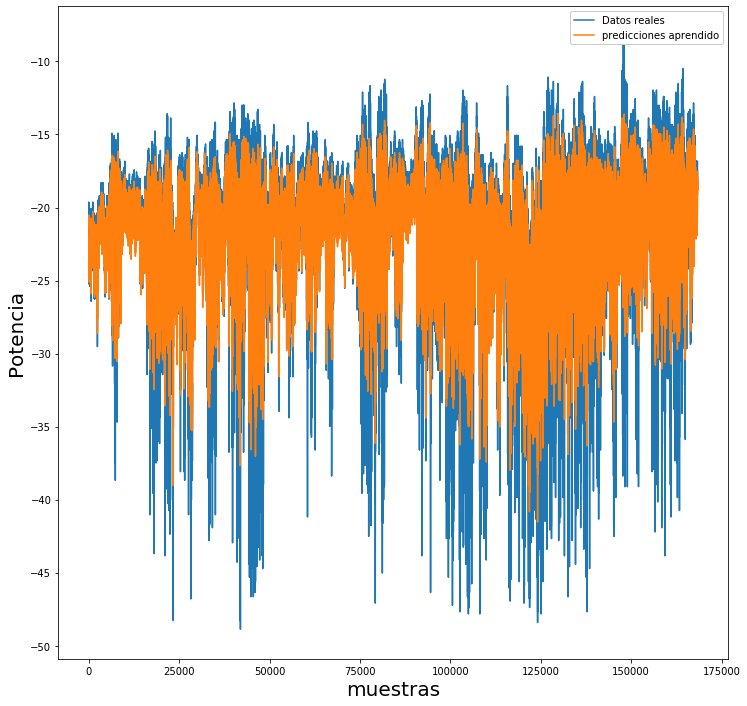

In [27]:
# plot entrenamiento
plt.figure(figsize=[12,12])
plt.plot(reales_train, label='Datos reales')
plt.plot(aprendido_train, label= 'predicciones aprendido')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

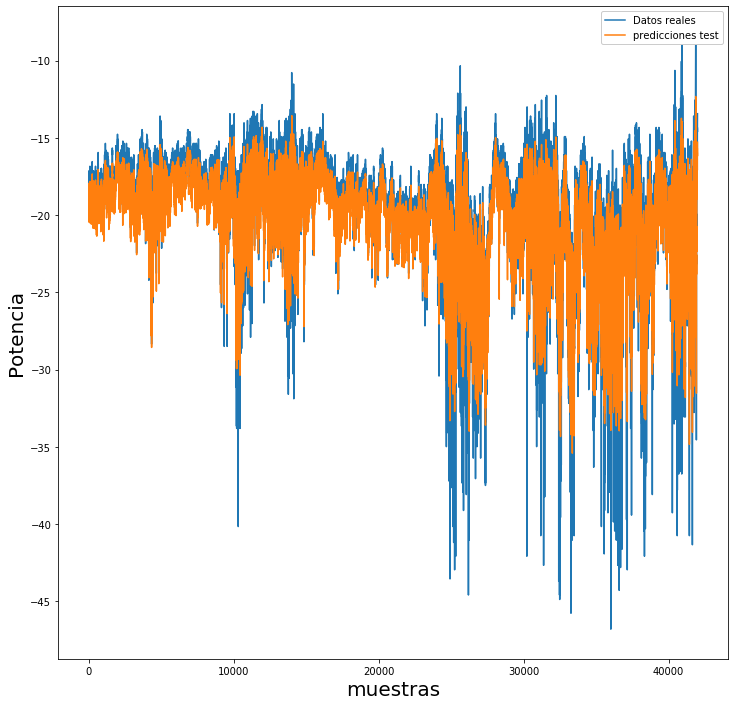

In [28]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test, label='Datos reales')
plt.plot(prediccion_test , label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

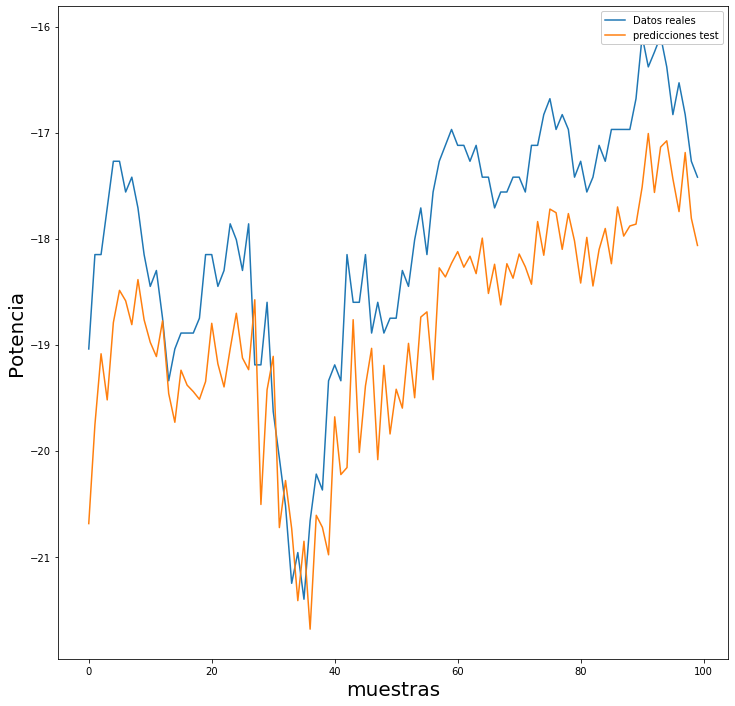

In [41]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test[1000:1100], label='Datos reales')
plt.plot(prediccion_test[1000:1100] , label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

In [30]:
acc = abs(prediccion_test-valor_real_test)
porc_error = (acc / abs(valor_real_test)) * 100
mostrar = valor_real_test, prediccion_test, acc, porc_error
Tabla_arr = np.array(mostrar)
Tabla = np.transpose(Tabla_arr)
Tabla=Tabla.reshape(len(acc), -1)
Tabla_df = pd.DataFrame(Tabla, columns=['Datos predichos','Datos reales','Error','Error porcentual'])
Tabla_df

,Datos predichos,Datos reales,Error,Error porcentual
0,-19.34,-20.429037,1.089037,5.631009
1,-18.89,-19.811811,0.921811,4.879891
2,-19.34,-19.468418,0.128418,0.664003
3,-19.34,-20.129942,0.789942,4.084498
4,-19.19,-19.754337,0.564337,2.940788
...,...,...,...,...
41983,-14.46,-16.174330,1.714330,11.855669
41984,-14.02,-15.926661,1.906661,13.599576
41985,-13.73,-15.540581,1.810581,13.187041
41986,-13.43,-15.466969,2.036969,15.167308


In [0]:
import seaborn as sns

In [0]:
aprendido_red=aprendido_train[:,0]
rial=reales_train[:,0]
testing=valor_real_test[:,0]
prediccion=prediccion_test[:,0]

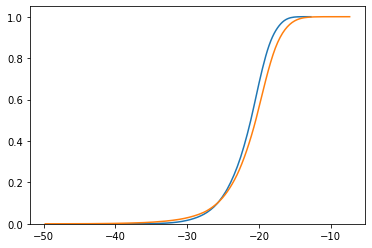

In [33]:
sns.kdeplot(aprendido_red, cumulative=True)
sns.kdeplot(rial, cumulative=True)

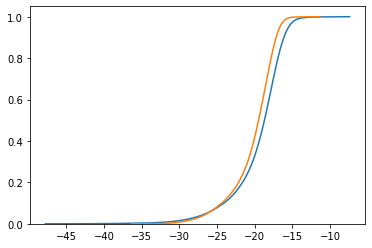

In [34]:
sns.kdeplot(testing, cumulative=True)
sns.kdeplot(prediccion, cumulative=True)

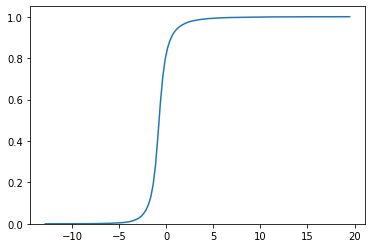

In [35]:
err=prediccion_test-valor_real_test
err_1=err[:,0]
sns.kdeplot(err_1, cumulative=True)

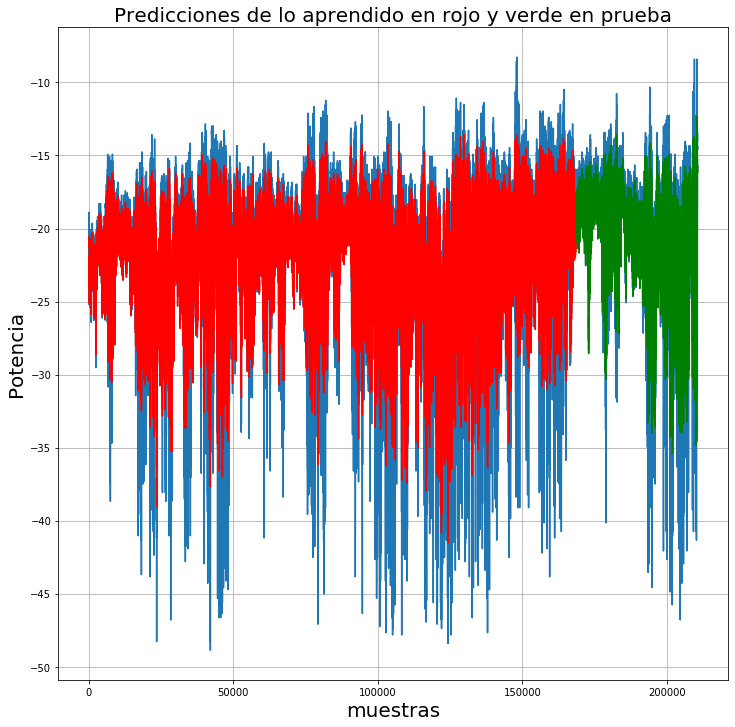

In [36]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(POT2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(aprendido_train)+look_back, :] = aprendido_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(POT2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(aprendido_train)+(look_back*2)+1:len(POT2)-1, :] = prediccion_test
# plot baseline and predictions
plt.figure(figsize=[12,12])
plt.plot((POT))
plt.plot(trainPredictPlot, color="red", )
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.plot(testPredictPlot, color="green")
plt.title("Predicciones de lo aprendido en rojo y verde en prueba", fontsize = 20)
plt.grid()
plt.show()